In [1]:
using DrWatson
@quickactivate "BNP2"
using Random, ProgressMeter, WeightsAndBiasLogger, MLDataUtils, BSON, Flux, Zygote
using MLToolkit.Neural, MLToolkit.DistributionsX
using Flux: Optimise
using Revise, BNP2

┌ Info: Precompiling MLDataUtils [cc2ba9b6-d476-5e6d-8eaf-a92d5412d41d]
└ @ Base loading.jl:1273
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1273
┌ Info: Precompiling MLToolkit [519e820e-097c-11e9-2274-1b004aeb0b9b]
└ @ Base loading.jl:1273
┌ Info: Precompiling BNP2 [8603dcfb-74c1-5750-99e2-e4446fa7f029]
└ @ Base loading.jl:1273


In [2]:
args = (
    seed        = 1110,
    dt          = 1f-1,
    n_trajs     = 10,
    is_noisyobs = false,
    σ_obs       = 1f-1,
    dataset     = "rand_init_three_body",
)

;

In [3]:
datafile = BSON.load(joinpath(datadir("diffeq-$(args.dataset)"), "data.bson"))

trajs, data = datafile[:trajs], datafile[:data]

@info "Loaded data" length(trajs.train) length(trajs.valid) length(trajs.test) length(data.train) length(data.valid) length(data.test)

;

SystemError: SystemError: opening file "/disk_c/sri/bnp2/data/diffeq-rand_init_three_body/data.bson": No such file or directory

(loss = 26.115963f0, loglikelihood = -26.115963f0)

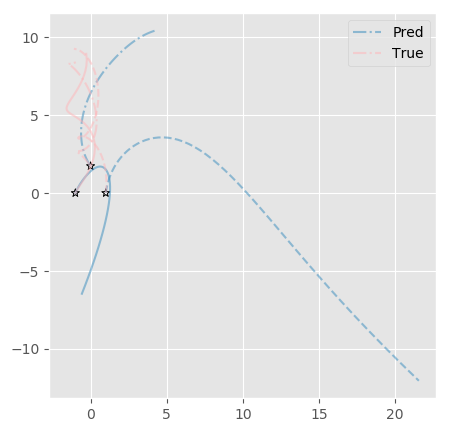

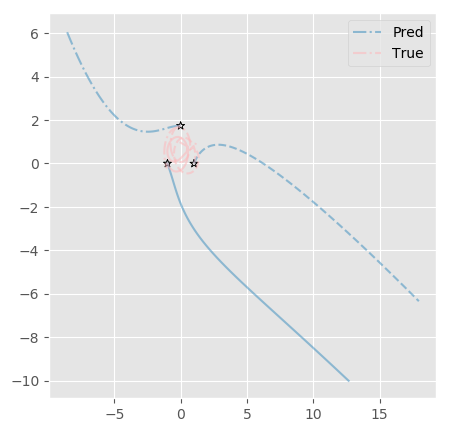

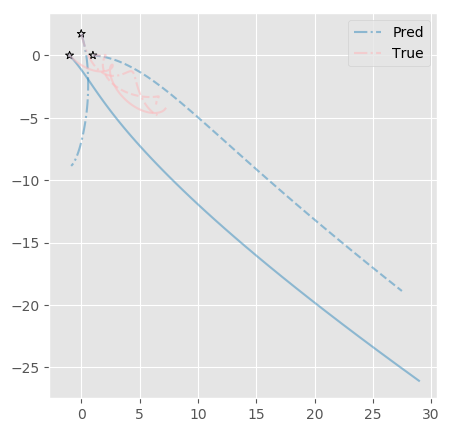

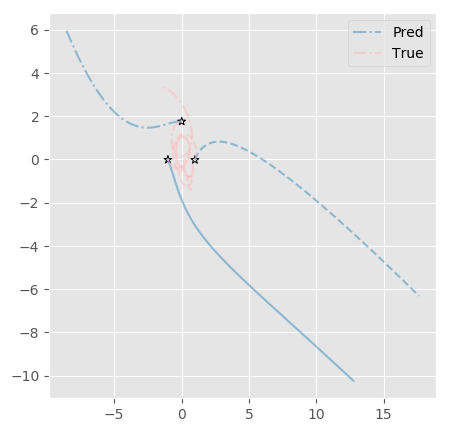

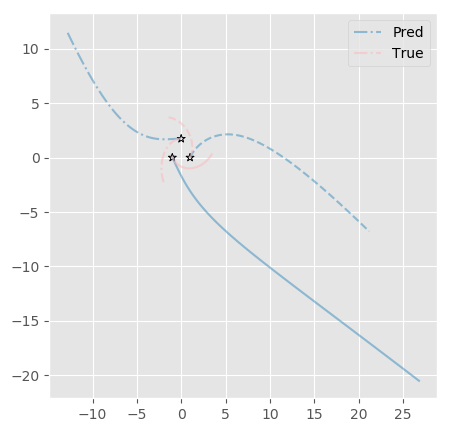

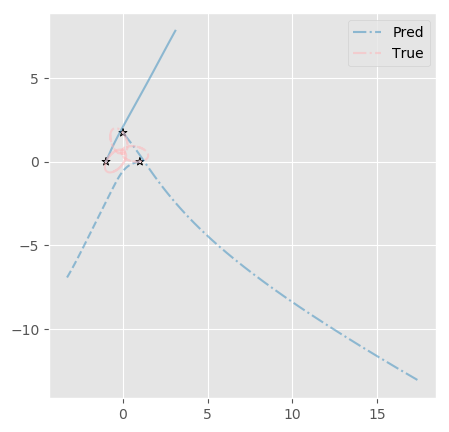

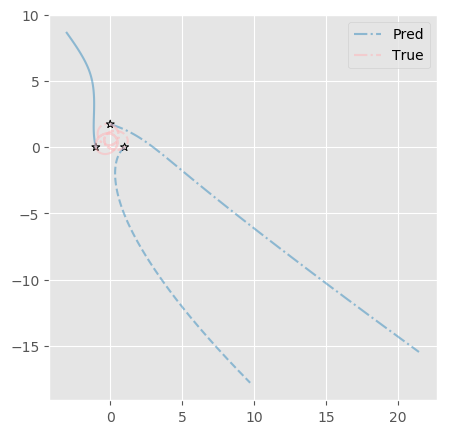

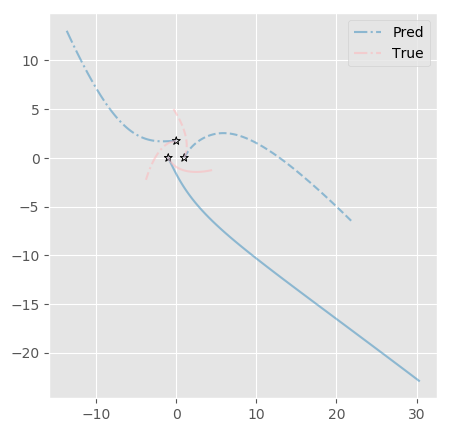

┌ Info: Main.Models.NeuralRelation{Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},DenseNet,Float32,Array{Float32,1}}(Dense(4, 50), DenseNet(Chain(Dense(100, 100), #30, Dense(100, 100), #30, Dense(100, 2))), 0.1f0, Float32[0.1])
└ @ Main In[23]:59


In [23]:
include(srcdir("Models.jl"))
import .Models
Zygote.refresh()

function predict(m::Models.DeepTransition, env, T)
    function envfrom(state)
        dim = div(size(state, 1), 2)
        return Space(Particle.(fill(5e10, 3), state[1:dim], state[dim+1:end]))
    end
    state = Vector{Float32}(vec(stateof(env)))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function predict(m, env, T)
    s = stateof(env)
    d, n = size(s, 2), size(s, 3)
    function envfrom(state)
        return Space(Particle.(fill(5e10, n), [state[1:d,i] for i in 1:n], [state[d+1:2d,i] for i in 1:n]))
    end
    state = Matrix{Float32}(cat(s[1,:,:], s[2,:,:]; dims=1))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function vis(
        m, trajs, T_ext::Int=0; 
        lws=["-", "--", "-."], fst=(color="black", marker="*")
)
    info = Dict()
    for (i, traj) in enumerate(trajs)
        traj_pred = predict(m, first(traj), length(traj) + T_ext - 1)
        
        fig, ax = figure(figsize=(5, 5))
        
        h1, = plot!(ax, traj_pred; lws=lws, first=fst)
        h2, = plot!(ax, traj; c=COLORS[:pink], lws=lws, first=fst)
        ax.legend([h1, h2], ["Pred", "True"], loc="upper right")
        
        info[Symbol("trajs[$i]")] = fig
    end
    return info
end

make_paired(batch) = tuple(batch[:,:,1:end-1,:], batch[:,:,2:end,:])

# model = Models.DeepTransition((100, 100, 100), args.σ_obs)
# model = Models.NeuralForce((100, 100, 100), args.dt, args.σ_obs)
# model = Models.NeuralBodyForce(50, (100, 100), args.dt, args.σ_obs)
model = Models.NeuralRelation(50, (100, 100), args.dt, args.σ_obs)
@info model

using Test

function test_estforce(model)
    x1 = rand(2 * 2, 1, 5)
    x2 = rand(2 * 2, 1, 5)
    x3 = x1
    x = cat(x1, x2, x3; dims=2)
    f = Models.estforce(model, x)
    @test f[:,1,:] == f[:,3,:]
end

let model=model, batch=data.train[:,1:10]
    test_estforce(model)
#     @code_warntype model(batch...)
    model(batch...) |> display
    gradient(params(model)) do
        model(batch...).loss
    end
    
    info = vis(model, data_raw.trajs_test[1:5:end])
    for fig in values(info)
        display(fig)
    end
end

;

In [24]:
logger = WBLogger(project=projectname(), notes="")
config!(logger, args)


wandb: Waiting for W&B process to finish, PID 27856
wandb: Program ended successfully.
wandb: Run summary:
wandb:                 _step 1391
wandb:   train/loglikelihood -124.16047668457031
wandb:              _runtime 1508.0139691829681
wandb:            train/loss 124.16047668457031
wandb:            _timestamp 1584044003.070394
wandb:   valid/loglikelihood -84.99446868896484
wandb:            valid/loss 84.99446868896484
wandb: Syncing 8 W&B file(s) and 256 media file(s)
wandb:                                                                                
wandb: Synced chocolate-frog-119: https://app.wandb.ai/xukai92/BNP2/runs/kz5jf913
wandb: Tracking run with wandb version 0.8.27
wandb: Wandb version 0.8.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Run data is saved locally in wandb/run-20200312_202351-oprx2so5
wandb: Syncing run blooming-silence-120
wandb: ⭐️ View project at https://app.wandb.ai/xukai92/BNP2
wandb: 🚀 View run at https://

In [31]:
let model=model, ps=params(model), n_epochs=200, opt=Optimise.ADAM(5f-4), batch_size=10
    with(logger) do
        @showprogress for epoch in 1:n_epochs
            for (iter, batch) in enumerate(eachbatch(values(shuffle(data.train)); size=batch_size))
                local info
                gs = gradient(ps) do
                    info = model(batch...)
                    info.loss
                end
                @info "train" info...
                Optimise.update!(opt, ps, gs)
            end
            @info "valid" model(data.test...)... vis(model, data_raw.trajs_test[1:5:end])...
        end
    end
    
    bson(datadir("$(split(string(typeof(model).name), ".")[end]).bson"), model=model)
end

;

Progress:  22%|████████▉                                |  ETA: 0:05:42

ArgumentError: ArgumentError: Attractive acceleration is undefined for 0 distance.

In [32]:
let model=model, traj_true=data_raw.trajs_test[21], T=length(traj_true)-1, T_ext=20
    traj = predict(model, first(traj_true), T + T_ext)
    HTML(animof(traj, traj_true).to_html5_video()) |> display
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABjEW1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAES5liIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhEj8xQEA3Pb/v95jiNln+tsq\nXw2YC3+Rdl8lTMe42EglZRNmT8ZPXQDcq3iSF4PcU2LIxZtvzMGBH5xxf1uV0GjKeFB7HYZxd+ni\nkUPgKPC4/9ApTnyEf2jr/ZcMVEMKly8DEblCjzpaq6+5hZ9L/eJ2698lfAJ5krIYyq1RsEBPBSbo\nQ3WxFAeFRhUlf8I/fFwqqqCphIYPYWLWlqYEfLWvgLIkAADJ/Ax66HeZp3L5pGvDnEAkjNrBirXH\n+7xMYg777EDpV2AjazvAOjXHskBovC1HO5E2ZKNE5N71cNiLV32XR/6+PGaOn7fzxEv3N10JzbQf\n69PuV818XTbZOSoMi91c8iPn9vmWS3RlIEPsvgR1d3nXVLT27PoPnRhudYRhxvsLANMdztOOPO9r\no/PPT9/roYDRmmomkTTa8Q7/DLUAvp86Q/xIOessrWR44+LiTMjar+B+UQXuba9Gdr0IIRSqkudN\nYgAAJXOgdjsSxqSd8B3X+GQB0vKETKYyHqI/Qjb5pXsZOCjMHxY4oVsWC82jFk470LqUzfUL9vJs\nF/7joyoewb7/NzgIAYj/Ke4jwDRUxmnZM6m8kDtvdZG7YoYrKxkqi2bFF6vqjL2SzxS2kQhFe7h1\nrgW9ZUzmwijej+uqdDRGcjbbxgMvEPd1F5IvffHymseWdeKYvtoz+P3mZZLaxL3ihCjrCWMw7vOu\nNYfz4y/7sW2ksV90tzUzxk+aZ7EoqVjKV0G8n1fzCnJ6WSItrdpUtiIV5yPv0Ua5gCbJC+oegYTP\nlYDGX97jMS6LADwO4u3O29xnKAeIGMEAByNUDDVMdPXMzsAADWCLAN8xjg5W7miqxrSooe7YRR2G\npoqtSzPonnK/arZAqFJkfPq4dZQaWgxFB9YJj8DKKEYtZU/M30VF/u0hwF7KKu2LrxCQB59UQYrE\nwuHZuhWYS8rrjmQHQHOwBeZTBmlEYDrtQuMTbGiEoJos4I17a4575JjGNYvpd79d99dPu5TUz5mJ\nC5dExGX7Xwy8JMCmqRFEqN0aQilutHs94MmWIgLLZIIxNPBZEVApeMZOOWt7hXqCKqv5Jz0/zutO\nHfFWKON80nvVezb3jTC4Xw8ROIoIt1Ag4y9AnvMRGIejg0WCOctyWjaBfhE4AAADAH0zPsUXjPvA\nNgWuGotIAMAhD/ToqZO3z8zpb4HT7lrCCBvkYM6LJZNYGbYawWslNlFhTVmpCVxaZQ+GdXR59Fhv\nwue9QOdwjnRM2+rzP8PTzT5aZCZDoBnRu98SSBdZbTUhuY9F0q9p1vPwUbjPuEP1wc9PRlX17n7N\nygF5whsqVUbGn9lCaM+D5WsaFbV6cw0NRvowbz3rR7PjMPilE1/q4Beeq+8HNLl+5aumm2PnH3wM\n0Dg+7lDnzqf5K8M3SIuSdQiZbVE2aj3Md0+tbXMRpEX1Sw/kJk30Wz55NctUSEQNvQYbgv00H+EB\nxE54AJHERKPJo470EAAN0omwifv6+gcJkkDj+h6J/36SvFfgYKVqPsLUKw72QwLuCL7vU5xANjTj\nv/2TfXti8vc56MF/GYNnUTuHRFC2WJQwPY1fppmmlwVsnNqwjDeZGYO6Ik71Bj4/4BjXIUqYv2e3\n73zuWykQP+lT2npF07cK8s0P8uUwV1YdZEtzWlCGAUfI01XVoJEqmIDP0S+gtLd9nlslGmhCgpu3\niFvET487+Gsh6NM4UUlMAMHiXj70r8Zu+g52tW2v4LmcbvekW65GnNrwVIn+lbnP9c1KtLU/OQq8\nv6ZsQsegoMgEvbDaXYNsJlPUk7/DS+asomErS60mmaLu+ynXGhDvAzRHxAlF+tMvQjvag+tYLvxk\nWSM37/vg8HVAK7ADdanxUwnxl5a3yioIOGiufrlx3sjfBuyL/JTJ63+xZP+NtYWI6QdGogvbPLu6\nZIv/IUGTV+91B1q1YqUG58duOEiFwziursNJcip5lFMqQBv4TBsU7WIyjPehabR9V6k5DjwyGCHY\n3iS4nVSCMFQrQ9EjgfIwja4arXJBac0gcgTOKb8lNmBDSKfHY9c3Y3PKkMSLpy2dJT3hKXnpi3IQ\nF+rUZp7kP1w8lhn8ew0oIPOusBnQ3JX7gde31tHgYgWKA84mXxW69ze0NLw3SvBxoVGxlEDE07/5\ngmZganPKynOGeQ2ZVt676D6pvEMRJELuAH+leqV5YieSYDB04BukRDCl09KqV3Nu8UqWOhztRwky\n4snX83tsbH8MiMuLQ/rUhn8SgBP0ir/Iv1SgYdd0SkP+0fFTO1K0mI1QYl6b9pHZO51xrACxyyPU\nEX3c2uUBDJep222fBfx7A18J9VUc/XEkWfnoLuvwrpge9j//AHuxouLKV+WvrjR5QFsOhxI1rdC7\nMfJCsCYtiUjGdfuZa7GOpr24XHF7icv1SNhOFQWohipepL/ZmcFuZ+b4JWArzk8z6MExaYV+epyC\nUhJ0B1aPlybmAA1JtA5Q/qJhhCrbIhWM/9OhF4oX2W6oj3sTRhHvwy3svG6ylDFSK32+PSFwboLn\nyZy1oyZHMKyikXnr7HxAklhcVSnpgfdMeK8AoW+i1Mhc3fOD6lbFiOjzZisvFekhg6GsbfTw7GnH\n5Le7igVqIOZqQXmeMPOpXrK/3XncZjwX/Xe9zaKOV67VNQ6ngAo1r24AgSFkcC/T9pNbBKATTpkj\nRPo4FCX9bn1K0jiKJK0c83mCdrQawqocHEppzJ/XwAAAD2

## MCMC

In [ ]:
@model three_body(ms, states, dt) = begin
    q ~ MvNormal(zeros(6), 10)
    p ~ MvNormal(zeros(6), 10)
    space = Space(Particle.(ms, q, p))
    for i in 1:length(states)
        space = transition(space, dt)
        states[i] ~ MvNormal(vec(stateof(space)), 1e-1)
    end
end

@time chn = sample(three_body(massof.(data.objs0), data.states, args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

bson(datadir("three_body-noise=$(args.σ).bson"), chn=chn)

;

let n_mc = 50, T = 100, do_mean = true, res = get(chn[end-n_mc+1:end], [:q, :p])
    Q = Matrix{Float64}(hcat(res.q...)')
    P = Matrix{Float64}(hcat(res.p...)')
    if do_mean
        Q = mean(Q; dims=2)
        P = mean(P; dims=2)
    end
    Q̂ = zeros(6, T)
    for i in 1:size(Q, 2)
        q, p = Q[:,i], P[:,i]
        space = Space(Particle.(data.ms, q, p))
        traj = simulate(space, args.dt, T)
        Q̂ = Q̂ + hcat(positionof.(traj)...)
    end
    Q̂ = Q̂ / size(Q, 2)
    HTML(animof(Q̂).to_html5_video()) |> display
end

;